In [3]:
import psutil
psutil.cpu_percent()
psutil.virtual_memory()

svmem(total=100981084160, available=85978533888, percent=14.9, used=11229048832, free=86277595136, active=3740643328, inactive=332140544, buffers=0, cached=3474440192, shared=3266482176, slab=459554816)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19, VGG16
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import to_categorical


from joblib import dump, load

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

Using TensorFlow backend.


# Import Data 

In [5]:
# Import data
train = pd.read_csv('fashion-mnist_train.csv')
train.shape

(60000, 785)

In [6]:
test = pd.read_csv('fashion-mnist_test.csv')
test.shape

(10000, 785)

In [7]:
# View data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,...,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,62,61,21,29,23,...,173,179,177,175,172,171,167,161,180,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,227,211,171,191,236,228,172,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,48,153,209,210,187,199,142,157,209,179,199,233,138,44,0,0,0,0,0,0,0,0,0,0,0,0,0,120,218,215,207,198,198,223,219,214,...,213,170,186,239,209,186,173,186,156,199,217,84,0,0,0,0,0,0,0,0,89,237,207,121,255,193,183,193,209,224,208,224,203,160,184,223,0,186,216,102,0,0,0,0,0,0,0,0,108,242,253,0,112,255,217,211,227,245,195,194,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,136,153,168,252,174,136,166,130,123,131,66,0,0,1,0,0,0,0,0,0,2,0,10,157,216,226,208,142,66,115,149,230,190,196,198,172,222,107,165,211,0,0,0,0,0,0,0,0,0,0,118,214,174,168,109,200,124,150,143,58,...,214,203,233,226,193,200,173,53,166,97,0,6,0,0,0,0,0,0,0,0,0,3,0,2,182,152,51,89,174,183,168,112,109,181,170,136,108,60,0,4,0,0,0,0,0,0,0,0,0,2,0,5,194,193,204,104,116,241,217,196,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,0,119,173,239,112,0,189,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,219,224,211,92,52,227,224,127,92,196,237,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,106,238,202,205,224,225,217,218,...,219,218,220,220,218,222,209,0,0,2,0

In [8]:
# Check class distribution for the labels
train['label'].value_counts(normalize = True)

9    0.1
8    0.1
7    0.1
6    0.1
5    0.1
4    0.1
3    0.1
2    0.1
1    0.1
0    0.1
Name: label, dtype: float64

In [9]:
# Separate X and y variables
X = train.drop('label', axis=1)
y = train.loc[:, 'label']

X_test = test.drop('label', axis=1)
y_test = test.loc[:, 'label']

print('Train Data:', X.shape, y.shape)
print('Test Data:', X_test.shape, y_test.shape)

Train Data: (60000, 784) (60000,)
Test Data: (10000, 784) (10000,)


In [10]:
# Standardize the X_train and X_test
X = X.astype('float32')
X = X/255

X_test = X_test.astype('float32')
X_test = X_test/255

In [11]:
# Add desc to label
label_dict = {0: "T-shirt/top", 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

def true_label(x):
    return label_dict[x]

# Train - Validation Set Split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

## VGG19

In [13]:
# Convert the images into 3 channels
X_train_vgg = np.dstack([X_train] * 3)
X_val_vgg = np.dstack([X_val] * 3)
X_test_vgg = np.dstack([X_test]*3)
print(X_train_vgg.shape, X_val_vgg.shape, X_test_vgg.shape)

# reshape image
X_train_vgg = X_train_vgg.reshape(-1, 28,28,3)
X_val_vgg = X_val_vgg.reshape(-1, 28,28,3)
X_test_vgg = X_test_vgg.reshape(-1, 28,28,3)
print(X_train_vgg.shape, X_val_vgg.shape, X_test_vgg.shape)

(48000, 784, 3) (12000, 784, 3) (10000, 784, 3)
(48000, 28, 28, 3) (12000, 28, 28, 3) (10000, 28, 28, 3)


In [14]:
# Resize the images 48x48 as required by VGG19
size = (90,90)
X_train_vgg = np.asarray([img_to_array(array_to_img(im, scale=False).resize(size)) for im in X_train_vgg])
X_val_vgg = np.asarray([img_to_array(array_to_img(im, scale=False).resize(size)) for im in X_val_vgg])
X_test_vgg = np.asarray([img_to_array(array_to_img(im, scale=False).resize(size)) for im in X_test_vgg])

print(X_train_vgg.shape, X_val_vgg.shape, X_test_vgg.shape)

(48000, 90, 90, 3) (12000, 90, 90, 3) (10000, 90, 90, 3)


In [15]:
y_train_vgg = to_categorical(y_train)
y_val_vgg = to_categorical(y_val)
y_test_vgg = to_categorical(y_test)
print(y_train_vgg.shape,y_val_vgg.shape, y_test_vgg.shape)

(48000, 10) (12000, 10) (10000, 10)


In [16]:
vgg19 = VGG19(weights= "models/VGG/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, 
              input_shape=(90, 90, 3))
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)       0     

In [17]:
# Preprocessing the input 
X_train_vgg = preprocess_input(X_train_vgg)
X_val_vgg = preprocess_input(X_val_vgg)
X_test_vgg = preprocess_input(X_test_vgg)
print(y_train_vgg.shape,y_val_vgg.shape, y_test_vgg.shape)

(48000, 10) (12000, 10) (10000, 10)


In [18]:
# Extracting features
train_features = vgg19.predict(np.array(X_train_vgg), 
                               batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val_vgg), 
                             batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test_vgg), 
                              batch_size=256, verbose=1)

10000/10000 [==============================] - 658s 66ms/step


In [19]:
# Saving the features so that they can be used for future
np.savez("models/train_features", train_features, y_train)
np.savez("models/test_features", test_features, y_test)
np.savez("models/val_features", val_features, y_val)
print(train_features.shape, test_features.shape, val_features.shape)

(48000, 2, 2, 512) (10000, 2, 2, 512) (12000, 2, 2, 512)


In [20]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (train_features.shape[0], 2*2*512))
test_features_flat = np.reshape(test_features, (test_features.shape[0], 2*2*512))
val_features_flat = np.reshape(val_features, (val_features.shape[0], 2*2*512))

In [33]:
# Add Dense and Dropout layers on top of VGG19 pre-trained
vgg19_model = Sequential([
    Dense(512,activation='relu', input_dim=2*2*512),
    Dropout(0.5),
    Dense(10,activation = 'softmax')
])

vgg19_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 1,054,218
Trainable params: 1,054,218
Non-trainable params: 0
_________________________________________________________________


In [34]:
import itertools

batch_size_lst = [32, 64, 128, 256]
epochs_lst = [50, 100]
learning_rate_lst = [0.0001, 0.001, 0.01, 0.1]
a = [batch_size_lst , epochs_lst , learning_rate_lst]
combinations = list(itertools.product(*a))

In [48]:
result_df = pd.DataFrame(columns = ['Batch_size', 'Epochs', 'Learning Rate', 'Train Accuracy', 
                                    'Test Accuracy', 'Train Loss', 'Test Loss'])

In [56]:
def vgg19(batch_size, epoch, lr):
    # compile
    vgg19_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = lr), metrics=['accuracy'])
    
    # callbacks
    reduce_learning = ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=2, verbose=1, 
                                              mode='auto', min_delta=0.0001, cooldown=2, min_lr=0)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0,mode='auto')
    checkpoint = ModelCheckpoint('models/vgg19.h5', monitor='val_accuracy', mode='max', save_best_only=True)
    callbacks = [early_stopping, checkpoint]
    
    # train the the model
    history = vgg19_model.fit(train_features_flat, y_train_vgg, epochs=epoch, batch_size = batch_size,
                          validation_data=(val_features_flat, y_val_vgg), verbose=0, callbacks = callbacks)
    
    # evaluate the model
    train_loss, train_acc = vgg19_model.evaluate(train_features_flat, y_train_vgg, verbose=0)
    test_loss, test_acc = vgg19_model.evaluate(test_features_flat, y_test_vgg, verbose=0)
    
    # save results
    return train_loss, train_acc, test_loss, test_acc

In [57]:
for i in range(len(combinations)):
    bs = combinations[i][0]
    ep = combinations[i][1]
    lr = combinations[i][2]
    print("------------ batch_size = {}, epoch = {}, lr = {} ------------".format(bs, ep, lr))
    train_loss, train_acc, test_loss, test_acc = vgg19(bs, ep, lr)
    result_df.loc[i] = [bs, ep, lr, train_acc, test_acc, test_loss, train_loss]

------------ batch_size = 32, epoch = 50, lr = 0.0001 ------------
------------ batch_size = 32, epoch = 50, lr = 0.001 ------------
------------ batch_size = 32, epoch = 50, lr = 0.01 ------------
------------ batch_size = 32, epoch = 50, lr = 0.1 ------------
------------ batch_size = 32, epoch = 100, lr = 0.0001 ------------
------------ batch_size = 32, epoch = 100, lr = 0.001 ------------
------------ batch_size = 32, epoch = 100, lr = 0.01 ------------
------------ batch_size = 32, epoch = 100, lr = 0.1 ------------
------------ batch_size = 64, epoch = 50, lr = 0.0001 ------------
------------ batch_size = 64, epoch = 50, lr = 0.001 ------------
------------ batch_size = 64, epoch = 50, lr = 0.01 ------------
------------ batch_size = 64, epoch = 50, lr = 0.1 ------------
------------ batch_size = 64, epoch = 100, lr = 0.0001 ------------
------------ batch_size = 64, epoch = 100, lr = 0.001 ------------
------------ batch_size = 64, epoch = 100, lr = 0.01 ------------
---------

In [58]:
result_df

,Batch_size,Epochs,Learning Rate,Train Accuracy,Test Accuracy,Train Loss,Test Loss
0,32.0,50.0,0.0001,0.100687,0.1,2.302594,2.302576
1,32.0,50.0,0.0010,0.100687,0.1,2.302666,2.302619
2,32.0,50.0,0.0100,0.099813,0.1,2.305199,2.305104
3,32.0,50.0,0.1000,0.099583,0.1,2.312547,2.312738
4,32.0,100.0,0.0001,0.100687,0.1,2.302594,2.302576
5,32.0,100.0,0.0010,0.100146,0.1,2.302618,2.302607
6,32.0,100.0,0.0100,0.100396,0.1,2.303721,2.303620
7,32.0,100.0,0.1000,0.100646,0.1,2.313424,2.312948
8,64.0,50.0,0.0001,0.100687,0.1,2.302595,2.302576
9,64.0,50.0,0.0010,0.100396,0.1,2.302614,2.302588


In [59]:
result_df.to_csv(r'vgg19_results.csv', index = False, header=True)

## Plot Model History

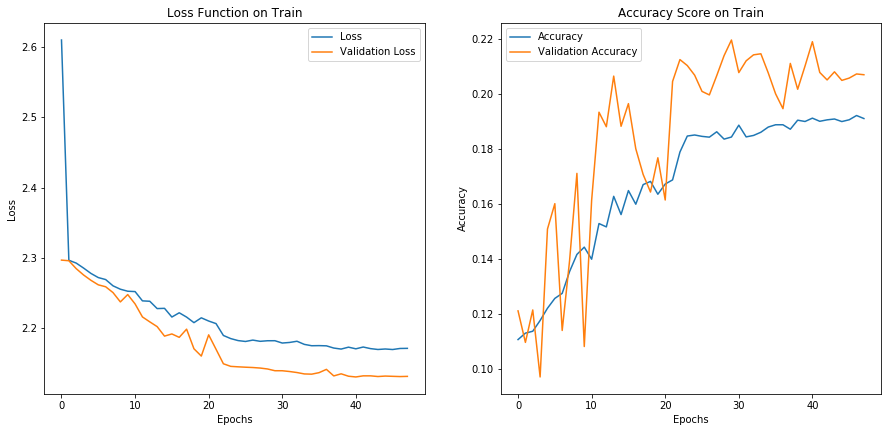

In [23]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Function on Train')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Score on Train')

plt.show()

In [26]:
pred_y = vgg19_model.predict(test_features_flat)
pred_y = np.argmax(np.round(pred_y),axis=1)
print(pred_y.shape, y_test.shape)

(10000,) (10000,)


In [27]:
from sklearn.metrics import classification_report
target_names = list(label_dict.values())
print(classification_report(y_test, pred_y, target_names=target_names))

             precision    recall  f1-score   support

T-shirt/top       0.10      1.00      0.18      1000
    Trouser       0.88      0.10      0.19      1000
   Pullover       0.69      0.03      0.05      1000
      Dress       0.00      0.00      0.00      1000
       Coat       0.00      0.00      0.00      1000
     Sandal       0.00      0.00      0.00      1000
      Shirt       0.00      0.00      0.00      1000
    Sneaker       0.00      0.00      0.00      1000
        Bag       0.00      0.00      0.00      1000
 Ankle boot       0.00      0.00      0.00      1000

avg / total       0.17      0.11      0.04     10000



/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
